In [153]:
import numpy as np
import pandas as pd
import gc

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv
from lifelines import KaplanMeierFitter
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import re
from scipy.stats import boxcox

# Clinical Data
df = pd.read_csv("./clinical_train.csv")
df_eval = pd.read_csv("./clinical_test.csv")

# Molecular Data
maf_df = pd.read_csv("./molecular_train.csv")
maf_eval = pd.read_csv("./molecular_test.csv")

target_df = pd.read_csv("./target_train.csv")
#target_df_test = pd.read_csv("./target_test.csv")

# Drop rows where 'OS_YEARS' is NaN if conversion caused any issues
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)


# Check the data types to ensure 'OS_STATUS' is boolean and 'OS_YEARS' is numeric
print(target_df[['OS_STATUS', 'OS_YEARS']].dtypes)

# Contarget_dfvert 'OS_YEARS' to numeric if it isn’t already
target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')

# Ensure 'OS_STATUS' is boolean
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool)

# Select features
features = ['BM_BLAST', 'HB', 'WBC', 'PLT']
target = ['OS_YEARS', 'OS_STATUS']

# Create the survival data format
X = df.loc[df['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

kmf = KaplanMeierFitter()
kmf.fit(y['OS_YEARS'], y['OS_STATUS'])
y_kaplan = kmf.survival_function_at_times(y['OS_YEARS']).values

OS_STATUS    float64
OS_YEARS     float64
dtype: object


In [154]:
# The validation set should be a similar size to the actual test set
val_set_size = len(df_eval)/len(X)

In [155]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val_set_size, random_state=42)
X_train_iter = X_train.copy()

from xgboost import XGBRegressor
# Survival-aware imputation for missing values
imputer = KNNImputer(n_neighbors=25)
#imputer = IterativeImputer(random_state=42)
# imputer = SimpleImputer(strategy="median")
#imputer = SimpleImputer(strategy="median")
X_train[['BM_BLAST', 'HB', 'WBC', 'PLT']] = imputer.fit_transform(X_train[['BM_BLAST', 'HB','WBC', 'PLT']])
X_test[['BM_BLAST', 'HB', 'WBC', 'PLT']] = imputer.transform(X_test[['BM_BLAST', 'HB', 'WBC', 'PLT']])



In [156]:
maf_df

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0
...,...,...,...,...,...,...,...,...,...,...,...
10930,P131472,NaN,NaN,NaN,NaN,NaN,MLL,MLL_PTD,PTD,NaN,NaN
10931,P131505,NaN,NaN,NaN,NaN,NaN,MLL,MLL_PTD,PTD,NaN,NaN
10932,P131816,NaN,NaN,NaN,NaN,NaN,MLL,MLL_PTD,PTD,NaN,NaN
10933,P132717,NaN,NaN,NaN,NaN,NaN,MLL,MLL_PTD,PTD,NaN,NaN


## Feature engineering helper functions


In [157]:
def extract_chromosomes(karyo):
    matches = re.findall(r'(?<!\d)(\d{1,2})(?!\d)', str(karyo))  # Extract chromosome numbers (1-22, X, Y)
    return len(set(matches))  # Count unique chromosomes affected

def count_deletions(karyo):
    return len(re.findall(r'del\(\d{1,2}\)', str(karyo)))  # Count deletions

def count_translocations(karyo):
    # Matches patterns like t(3;3), t(3;X), etc.
    return len(re.findall(r't\([\dxy;]+\)', str(karyo)))  # Count translocations

def frameshift_ratio(df):
    total_mutations = df.shape[0]
    if total_mutations == 0:
        return 0
    frameshift_mutations = df[df['EFFECT'] == 'frameshift_variant'].shape[0]
    return frameshift_mutations / total_mutations

def extract_cytogenetics_info(cytogenetics):
    if pd.isna(cytogenetics):
        return 0  # Handle missing values
    # Example: Count the number of abnormalities
    abnormalities = cytogenetics.split(',')
    return len(abnormalities)

def chr_density(chromosome_number, df, df_main, chromosome_length):
    df['CHR'] = df['CHR'].astype(str).str.strip()
    df[f'is_chr{chromosome_number}'] = df['CHR'].apply(lambda x: 1 if x == chromosome_number else 0)

    new_col_name = 'chr'+chromosome_number

    chr_counts = df.groupby('ID').agg(
        **{new_col_name: (f'is_chr{chromosome_number}', 'sum')}
    ).reset_index()

    chr_counts[f'chr{chromosome_number}_mutation_density'] = chr_counts[new_col_name] / chromosome_length

    df_main = df_main.merge(chr_counts[['ID', f'chr{chromosome_number}_mutation_density']], on='ID', how='left').fillna(
        {f'chr{chromosome_number}_mutation_density': 0}
    )

    return df_main

In [158]:
tmp = maf_df.groupby('ID').size().reset_index(name='Nmut')
df_2 = df.merge(tmp, on='ID', how='left').fillna({'Nmut': 0})

# Step: Aggregate the VAF values per patient
vaf_agg = maf_df.groupby('ID')['VAF'].mean().reset_index(name='VAF_mean')
vaf_sum = maf_df.groupby('ID')['VAF'].sum().reset_index(name='VAF_sum')

# Merge the aggregated VAF values into the main dataframe
df_2 = (df_2.merge(vaf_agg, on='ID', how='left')
              .merge(vaf_sum, on='ID', how='left')
              .fillna({'VAF_mean': 0, 'VAF_sum': 0}))

# Count the number of unique genes affected per patient
unique_genes = maf_df.groupby('ID')['GENE'].nunique().reset_index(name='unique_genes    ')

df_2 = df_2.merge(unique_genes, on='ID', how='left').fillna({'unique_genes': 0})

genes = ['TP53', 'FLT3']
for gene in genes:
    vaf_gene = maf_df[maf_df['GENE'] == gene].groupby('ID')['VAF'].mean().reset_index(name=f'VAF_{gene}')
    df_2 = df_2.merge(vaf_gene, on='ID', how='left').fillna({f'VAF_{gene}': 0})

# Number of duplications
# This counts the occurrences of "dup(" in the CYTOGENETICS string.
df_2['num_duplications'] = df_2['CYTOGENETICS'].str.count(r'dup\(')

# Number of unique chromosomes mutated
df_2['num_unique_chromosomes'] = df_2['CYTOGENETICS'].apply(extract_chromosomes)

# Number of deleted chromosomes
df_2['num_deletions'] = df_2['CYTOGENETICS'].apply(count_deletions)

# Count translocations
df_2['num_translocations'] = df_2['CYTOGENETICS'].apply(count_translocations)

# Compute frameshift ratio per patient
frameshift_df = maf_df.groupby('ID').apply(frameshift_ratio).reset_index(name='frameshift_ratio')
df_2 = df_2.merge(frameshift_df, on='ID', how='left').fillna({'frameshift_ratio': 0})

df_2['cytogenetics_abnormalities'] = df_2['CYTOGENETICS'].apply(extract_cytogenetics_info)

# Fraction of Deletions: Proportion of deletions among all cytogenetic abnormalities
df_2['frac_deletions'] = df_2['num_deletions'] / df_2['cytogenetics_abnormalities'].replace(0, np.nan)
df_2.fillna({'frac_deletions' :0}, inplace=True)

chromosome_lengths = {'7': 159345973/1e6,
                      # '4': 191273063/1e6,
                      # '2': 242193529/1e6,
                      # '17': 84276897/1e6
                      }

for i in chromosome_lengths.keys():
    df_2 = chr_density(i, maf_df, df_2, chromosome_lengths[i])

df_2.head()

C:\Users\johnn\AppData\Local\Temp\ipykernel_12936\1229901308.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  frameshift_df = maf_df.groupby('ID').apply(frameshift_ratio).reset_index(name='frameshift_ratio')


,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,Nmut,...,VAF_TP53,VAF_FLT3,num_duplications,num_unique_chromosomes,num_deletions,num_translocations,frameshift_ratio,cytogenetics_abnormalities,frac_deletions,chr7_mutation_density
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]",9.0,...,0.0,0.1155,0.0,5,1,0,0.333333,4,0.25,0.000000
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx",3.0,...,0.0,0.0000,0.0,1,0,0,0.666667,2,0.00,0.000000
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]",3.0,...,0.0,0.0000,0.0,6,0,1,0.000000,4,0.00,0.006276
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]",11.0,...,0.0,0.0000,0.0,6,1,0,0.090909,4,0.25,0.018827
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]",1.0,...,0.0,0.0000,0.0,6,0,1,1.000000,4,0.00,0.000000


## Variance inflation factor

                   feature       VIF
0                 BM_BLAST  1.879356
1                       HB  6.433553
2                      WBC  1.533436
3                      PLT  2.216915
4                     Nmut  4.076041
5   num_unique_chromosomes  5.095582
6           frac_deletions  3.654682
7            num_deletions  4.952112
8         num_duplications  1.029231
9                 VAF_mean  4.267769
10        frameshift_ratio  1.810425
11      num_translocations  1.458392
12   chr7_mutation_density  1.356913
13                VAF_TP53  2.032737
14                VAF_FLT3  1.036298


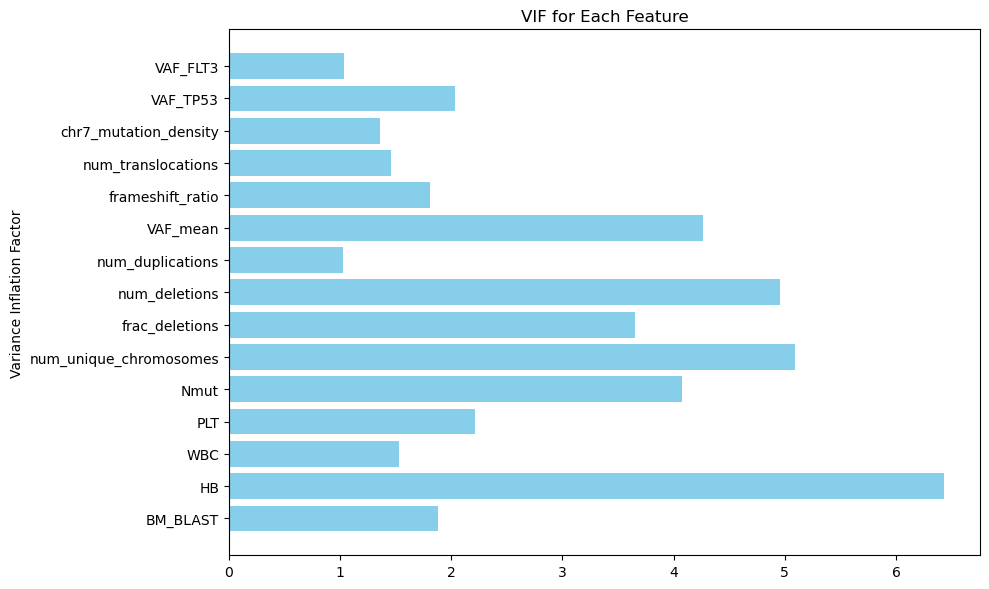

In [159]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vaf_genes = [f'VAF_{gene}' for gene in genes]
features = [ 'BM_BLAST','HB', 'WBC', 'PLT', 'Nmut', 'num_unique_chromosomes', 'frac_deletions',
            'num_deletions', 'num_duplications', 'VAF_mean', 'frameshift_ratio', 'num_translocations',
             'chr7_mutation_density']  +  vaf_genes

# features = [ 'BM_BLAST', 'WBC', 'PLT', 'num_unique_chromosomes', 'frac_deletions',
#             'num_deletions', 'num_duplications', 'VAF_mean', 'frameshift_ratio', 'num_translocations',
#              'chr7_mutation_density', 'chr4_mutation_density', 'chr2_mutation_density', 'chr17_mutation_density']  +  vaf_genes
target = ['OS_YEARS', 'OS_STATUS']

X = df_2.loc[df_2['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

# Select only numeric columns from X
X_numeric = X.select_dtypes(include=[np.number])

# Replace infinite values with NaN
X_numeric = X_numeric.replace([np.inf, -np.inf], np.nan)

# Fill missing values with the mean of each column
X_numeric_clean = X_numeric.fillna(X_numeric.mean())

# Calculate VIF for each numeric feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric_clean.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric_clean.values, i)
                   for i in range(X_numeric_clean.shape[1])]

# Display the VIF values
print(vif_data)

# Plot the VIF values
plt.figure(figsize=(10, 6))
plt.barh(vif_data['feature'], vif_data['VIF'], color='skyblue')

plt.ylabel("Variance Inflation Factor")
plt.title("VIF for Each Feature")
plt.tight_layout()
plt.show()

In [160]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val_set_size, random_state=42)
# Survival-aware imputation for missing values

#imputer = IterativeImputer(random_state=42)
# imputer = SimpleImputer(strategy="median")
imputer = KNNImputer(n_neighbors=25)
X_train[features] = imputer.fit_transform(X_train[features])
X_test[features] = imputer.transform(X_test[features])

kmf_train = KaplanMeierFitter()
kmf_train.fit(y_train['OS_YEARS'], y_train['OS_STATUS'])
y_surv_train = kmf_train.survival_function_at_times(y_train['OS_YEARS']).values
y_surv_val = kmf_train.survival_function_at_times(y_test['OS_YEARS']).values

## Extra Survival Trees

In [161]:
from sksurv.ensemble import ExtraSurvivalTrees, RandomSurvivalForest, GradientBoostingSurvivalAnalysis

# Train Extra Survival Trees model
extra_trees = ExtraSurvivalTrees(n_estimators=700, max_depth=15,random_state=42, n_jobs=4)
extra_trees.fit(X_train, y_train)

# Make predictions
predictions = extra_trees.predict(X_test)

# Evaluate the model using Concordance Index IPCW
extra_trees_cindex_test = concordance_index_ipcw(y_train, y_test, predictions, tau=7)[0]
print(f"Extra Survival Trees Concordance Index IPCW on test: {extra_trees_cindex_test:.4f}")

KeyboardInterrupt: 

In [11]:
# from sklearn.inspection import permutation_importance
# # Feature importance for Extra Survival Trees
#
# def perm_imp(model, X, y, n_repeats=10, random_state=42):
#     est_importances_train = permutation_importance(extra_trees, X_train, y_train, n_repeats=5, random_state=42)
#     perm_imps = pd.DataFrame(
#         {
#             k: est_importances_train[k]
#             for k in (
#             "importances_mean",
#             "importances_std"
#         )
#         },
#         index=X_train.columns,
#     ).sort_values(by='importances_mean', ascending=False)
#     print(perm_imps)
#
#     return perm_imps
#
# perm_imp = perm_imp(extra_trees, X_train, y_train)

In [13]:
# plt.figure(figsize=(10, 6))
# plt.barh(perm_imp.index, perm_imp['importances_mean'], color='skyblue')
#
# plt.ylabel("Extra Survival Trees Permutation Importance mean")
# plt.title("Importance")
# plt.tight_layout()
# plt.show()

In [15]:
# import numpy as np
# from sksurv.ensemble import ExtraSurvivalTrees
# from sksurv.metrics import concordance_index_ipcw, concordance_index_censored
# from sklearn.model_selection import RandomizedSearchCV, KFold
# from sklearn.metrics import make_scorer
#
#
# # Define a scorer compatible with scikit-learn that uses the censored concordance index.
# # It relies only on y_true and predictions, which works inside CV folds.
# def cindex_censored_scorer(y_true, y_pred):
#     return concordance_index_censored(y_true['OS_STATUS'], y_true['OS_YEARS'], y_pred)[0]
#
#
# scorer = make_scorer(cindex_censored_scorer, greater_is_better=True)
#
# # Hyperparameter distributions for randomized search
# param_distributions = {
#     'n_estimators': np.arange(300, 601),  # 300..600 inclusive
#     'max_depth': np.arange(10, 17),  # 10..16 inclusive
# }
#
# base_model = ExtraSurvivalTrees(random_state=42)
#
# # 5-fold CV with shuffling for robust estimates
# cv = KFold(n_splits=3, shuffle=True, random_state=42)
#
# search = RandomizedSearchCV(
#     estimator=base_model,
#     param_distributions=param_distributions,
#     n_iter=5,
#     scoring=scorer,
#     cv=cv,
#     random_state=42,
#     n_jobs=-1,
#     verbose=1,
# )
#
# # Run the randomized search
# search.fit(X_train, y_train)
# print("Best parameters (RandomizedSearchCV):", search.best_params_)
# print("Best mean CV c-index (censored):", search.best_score_)
#
# # Refit best estimator on the full training data (RandomizedSearchCV already does refit=True by default)
# extra_trees = search.best_estimator_
#
# # Evaluate on hold-out test set using IPCW to keep comparability with previous reporting
# predictions = extra_trees.predict(X_test)
# extra_trees_cindex_test = concordance_index_ipcw(y_train, y_test, predictions, tau=7)[0]
# print(f"Extra Survival Trees (best) IPCW on test: {extra_trees_cindex_test:.4f}")

In [16]:
## FINAL MODEL
# extra_trees = ExtraSurvivalTrees(n_estimators=400, max_depth=14,random_state=42, n_jobs=-1)
# extra_trees.fit(X_train, y_train)
#
# # Make predictions
# predictions = extra_trees.predict(X_test)
#
# # Evaluate the model using Concordance Index IPCW
# extra_trees_cindex_test = concordance_index_ipcw(y_train, y_test, predictions, tau=7)[0]
# print(f"Extra Survival Trees Concordance Index IPCW on test: {extra_trees_cindex_test:.4f}")

In [19]:
# from sklearn.model_selection import KFold
#
# def cv_train(model, X_df, y_df, model_name):
#     scores = []
#     kf = KFold(n_splits=3, shuffle=True, random_state=30)
#     fold = 0
#     print(f"{model_name} scores")
#     for train, val in kf.split(X_df, y_df):
#         fold += 1
#         X_train_fold, X_val_fold = X_df.iloc[train], X_df.iloc[val]
#         y_train_fold, y_val_fold = y_df[train], y_df[val]
#
#         model.fit(X_train_fold, y_train_fold)
#         preds = model.predict(X_val_fold)
#
#         score = concordance_index_ipcw(y_train_fold, y_val_fold, preds, tau=7)[0]
#
#         scores.append(score)
#         print(f"Fold {fold}: {score:.4f}")
#     return scores
#
#
# est_scores = cv_train(extra_trees, X_train, y_train, "EST")



In [162]:
df_eval = pd.read_csv("./clinical_test.csv")

tmp_eval = maf_eval.groupby('ID').size().reset_index(name='Nmut')

# Merge with the training dataset and replace missing values in 'Nmut' with 0
df_eval = df_eval.merge(tmp_eval, on='ID', how='left').fillna({'Nmut': 0})

# Step: Aggregate the VAF values per patient
vaf_agg = maf_eval.groupby('ID')['VAF'].sum().reset_index(name='VAF_mean')
#vaf_sum = maf_eval.groupby('ID')['VAF'].sum().reset_index(name='VAF_sum')

# Merge the aggregated VAF values into the main dataframe
df_eval = df_eval.merge(vaf_agg, on='ID', how='left').fillna({'VAF_mean': 0})
#df_eval = df_eval.merge(vaf_sum, on='ID', how='left').fillna({'VAF_sum': 0})

# Count the number of unique genes affected per patient
unique_genes = maf_eval.groupby('ID')['GENE'].nunique().reset_index(name='unique_genes')


df_eval = df_eval.merge(unique_genes, on='ID', how='left').fillna({'unique_genes': 0})

genes = ['TP53', 'FLT3']
for gene in genes:
    vaf_gene_eval = maf_eval[maf_eval['GENE'] == gene].groupby('ID')['VAF'].mean().reset_index(name=f'VAF_{gene}')
    df_eval = df_eval.merge(vaf_gene_eval, on='ID', how='left').fillna({f'VAF_{gene}': 0})

# # Example: VAF for mutations in TP53
# vaf_tp53 = maf_eval[maf_eval['GENE'] == 'TP53'].groupby('ID')['VAF'].mean().reset_index(name='VAF_TP53')
# df_eval = df_eval.merge(vaf_tp53, on='ID', how='left').fillna({'VAF_TP53': 0})
#
#
# vaf_flt3 = maf_eval[maf_eval['GENE'] == 'FLT3'].groupby('ID')['VAF'].mean().reset_index(name='VAF_FLT3')
# df_eval = df_eval.merge(vaf_flt3, on='ID', how='left').fillna({'VAF_FLT3': 0})

df_eval['num_unique_chromosomes'] = df_eval['CYTOGENETICS'].apply(extract_chromosomes)

df_eval['num_deletions'] = df_eval['CYTOGENETICS'].apply(count_deletions)

# Apply the function to create a new feature
df_eval['cytogenetics_abnormalities'] = df_eval['CYTOGENETICS'].apply(extract_cytogenetics_info)

df_eval['num_duplications'] = df_eval['CYTOGENETICS'].str.count(r'dup\(')

df_eval['frac_deletions'] = df_eval['num_deletions'] / df_eval['cytogenetics_abnormalities'].replace(0, np.nan)
df_eval.fillna({'frac_deletions': 0}, inplace=True)

frameshift_df = maf_df.groupby('ID').apply(frameshift_ratio).reset_index(name='frameshift_ratio')
df_eval = df_eval.merge(frameshift_df, on='ID', how='left').fillna({'frameshift_ratio': 0})
df_eval['num_translocations'] = df_eval['CYTOGENETICS'].apply(count_translocations)

for i in chromosome_lengths.keys():
    df_eval = chr_density(i, maf_eval, df_eval, chromosome_lengths[i])

C:\Users\johnn\AppData\Local\Temp\ipykernel_12936\1008063531.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  frameshift_df = maf_df.groupby('ID').apply(frameshift_ratio).reset_index(name='frameshift_ratio')


In [163]:
df_eval[features] = imputer.transform(df_eval[features])

prediction_on_test_set = extra_trees.predict(df_eval.loc[:, features])
# rsf_test_pred = rsf.predict(df_eval.loc[:, features])

weighted_preds = prediction_on_test_set

## Adversarial validation

In [164]:
features_new = features + ['label']

In [168]:
# X_av = X.copy()
# X_av.loc[:, features_new] = imputer.fit_transform(X.loc[:, features_new])
# pd.concat([X.loc[:, features_new], df_eval.loc[:, features_new]], axis=1)


In [169]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import xgboost as xgb
X['label'] = 0
df_eval['label'] = 1

X_av = X.copy()
df_eval_av = df_eval.copy()

X_av.loc[:, features] = imputer.fit_transform(X_av.loc[:, features])
df_eval_av.loc[:, features] = imputer.transform(df_eval.loc[:, features])

# merge into one big dataset
X_av_final = pd.concat([X.loc[:, features_new], df_eval.loc[:, features_new]], axis=0, ignore_index=True)


In [170]:
X_av_final

,BM_BLAST,HB,WBC,PLT,Nmut,num_unique_chromosomes,frac_deletions,num_deletions,num_duplications,VAF_mean,frameshift_ratio,num_translocations,chr7_mutation_density,VAF_TP53,VAF_FLT3,label
0,14.000,7.60000,2.8000,119.00,9.0,5.0,0.25,1.0,0.0,0.251578,0.333333,0.0,0.000000,0.000,0.1155,0
1,1.000,11.60000,7.4000,42.00,3.0,1.0,0.00,0.0,0.0,0.272867,0.666667,0.0,0.000000,0.000,0.0000,0
2,15.000,14.20000,3.7000,81.00,3.0,6.0,0.00,0.0,0.0,0.039333,0.000000,1.0,0.006276,0.000,0.0000,0
3,1.000,8.90000,3.9000,77.00,11.0,6.0,0.25,1.0,0.0,0.209227,0.090909,0.0,0.018827,0.000,0.0000,0
4,6.000,11.10000,128.0000,195.00,1.0,6.0,0.00,0.0,0.0,0.472100,1.000000,1.0,0.000000,0.000,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4361,4.880,9.92036,5.9900,221.08,2.0,0.0,0.00,0.0,0.0,0.891000,0.000000,0.0,0.000000,0.000,0.0000,1
4362,4.056,9.47120,6.4776,213.00,3.0,0.0,0.00,0.0,0.0,1.316000,0.000000,0.0,0.000000,0.000,0.0000,1
4363,4.500,9.53860,4.1964,148.40,1.0,0.0,0.00,0.0,0.0,0.122000,0.000000,0.0,0.000000,0.122,0.0000,1
4364,3.936,9.66720,6.7844,218.44,3.0,0.0,0.00,0.0,0.0,0.917000,0.000000,0.0,0.006276,0.000,0.0000,1


In [171]:
X1

,BM_BLAST,HB,WBC,PLT,Nmut,num_unique_chromosomes,frac_deletions,num_deletions,num_duplications,VAF_mean,frameshift_ratio,num_translocations,chr7_mutation_density,VAF_TP53,VAF_FLT3
0,14.000,7.60000,2.8000,119.00,9.0,5.0,0.25,1.0,0.0,0.251578,0.333333,0.0,0.000000,0.000,0.1155
1,1.000,11.60000,7.4000,42.00,3.0,1.0,0.00,0.0,0.0,0.272867,0.666667,0.0,0.000000,0.000,0.0000
2,15.000,14.20000,3.7000,81.00,3.0,6.0,0.00,0.0,0.0,0.039333,0.000000,1.0,0.006276,0.000,0.0000
3,1.000,8.90000,3.9000,77.00,11.0,6.0,0.25,1.0,0.0,0.209227,0.090909,0.0,0.018827,0.000,0.0000
4,6.000,11.10000,128.0000,195.00,1.0,6.0,0.00,0.0,0.0,0.472100,1.000000,1.0,0.000000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4361,4.880,9.92036,5.9900,221.08,2.0,0.0,0.00,0.0,0.0,0.891000,0.000000,0.0,0.000000,0.000,0.0000
4362,4.056,9.47120,6.4776,213.00,3.0,0.0,0.00,0.0,0.0,1.316000,0.000000,0.0,0.000000,0.000,0.0000
4363,4.500,9.53860,4.1964,148.40,1.0,0.0,0.00,0.0,0.0,0.122000,0.000000,0.0,0.000000,0.122,0.0000
4364,3.936,9.66720,6.7844,218.44,3.0,0.0,0.00,0.0,0.0,0.917000,0.000000,0.0,0.006276,0.000,0.0000


In [190]:
X1 = X_av_final.drop(columns='label', axis=1)
y1 = X_av_final['label']
XGB_av_data = xgb.DMatrix(data=X1, label=y1)
params = {"objective": "binary:logistic",
          "eval_metric": "logloss",
          "learning_rate": 0.05,
          "max_depth": 5}

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for trn_idx, val_idx in folds.split(X1, y1):
        xgb_cls = XGBClassifier(**params)
    xgb_cls.fit(X1.iloc[trn_idx], y1.iloc[trn_idx])
    print(roc_auc_score(y1.iloc[val_idx], xgb_cls.predict(X1.iloc[val_idx])))

0.8677199798615003
0.8924649902625076
0.9003817574152694


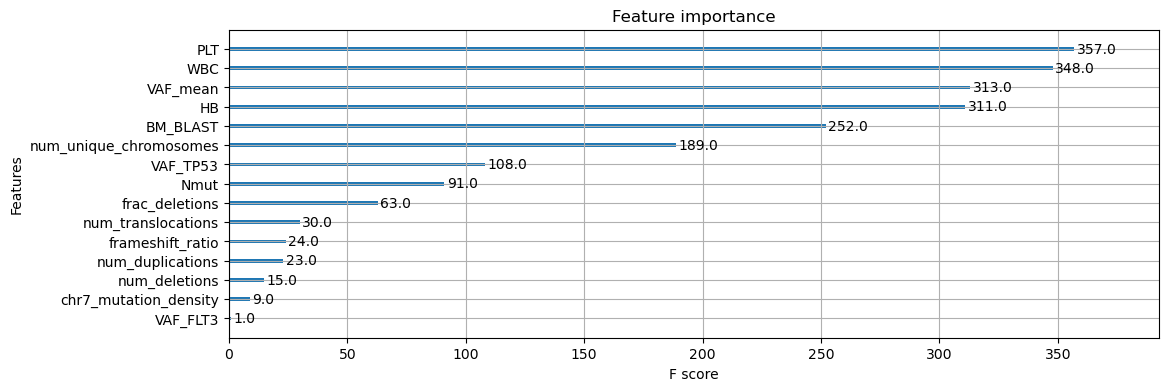

In [173]:
# Look at adversarial feature importance
from xgboost import plot_importance
classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
classifier.fit(X1, y1)
fig, ax = plt.subplots(figsize=(12,4))
plot_importance(classifier, ax=ax)
plt.show();

In [174]:
# let's drop features which have high adversarial importance i.e. they help to distinguish test
av_features = ['PLT', 'WBC', 'VAF_mean', 'HB', 'BM_BLAST', 'num_unique_chromosomes']
X2 = X_av_final.drop(columns=['label', 'PLT', 'WBC', 'VAF_mean', 'HB', 'BM_BLAST', 'num_unique_chromosomes'], axis=1)
y2 = X_av_final['label']
XGB_av_data = xgb.DMatrix(data=X2, label=y2)
params = {"objective": "binary:logistic",
          "eval_metric": "logloss",
          "learning_rate": 0.05,
          "max_depth": 5}

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=2)

for trn_idx, val_idx in folds.split(X2, y2):
    xgb_cls = XGBClassifier(**params)
    xgb_cls.fit(X2.iloc[trn_idx], y2.iloc[trn_idx])
    print(roc_auc_score(y2.iloc[val_idx], xgb_cls.predict(X2.iloc[val_idx])))

0.6776035185378688
0.6948665082637742
0.6771130962285411


_These are pretty alarming results, Extra Survival Trees have managed to reduce overfitting through their randomized feature splitting mechanisms but it's clear that the distributions of some covariates (which also have predictive power) are distributed very differently among the test and train datasets.

This will explain some of the poor generalisations of our previous models (specifically gradient boosters), and how Random Forests + Extra Trees perform better on LB.

What we will do is try different transformations on features with high adversarial importance such that our train set will be more representative of the LB.

In [175]:
from sklearn.preprocessing import PowerTransformer
yj = PowerTransformer(method='yeo-johnson')

In [187]:
# Yeo-Johnson transformation on the training data only
X_yj = X.copy()
df_eval_yj = df_eval.copy()

# Impute with our KNNImputer
X_yj.loc[:, features] = imputer.fit_transform(X_yj.loc[:, features])
df_eval_yj.loc[:, features] = imputer.transform(df_eval_yj.loc[:, features])

# Yeo-Johnson transformation
X_yj.loc[:, av_features] = yj.fit_transform(X_yj.loc[:, av_features])
df_eval_yj.loc[:, av_features] = yj.transform(df_eval_yj.loc[:, av_features])

# merge into one big dataset
X_yj_final = pd.concat([X_yj.loc[:, features_new], df_eval_yj.loc[:, features_new]], axis=0, ignore_index=True)

X3 = X_yj_final.drop(columns='label', axis=1)
y3 = X_yj_final['label']

XGB_av_data_yj = xgb.DMatrix(data=X3, label=y3)

params = {"objective": "binary:logistic",
          "eval_metric": "logloss",
          "learning_rate": 0.05,
          "max_depth": 5}

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for trn_idx, val_idx in folds.split(X3, y3):
    xgb_cls = XGBClassifier(**params)
    xgb_cls.fit(X3.iloc[trn_idx], y3.iloc[trn_idx])
    print(roc_auc_score(y3.iloc[val_idx], xgb_cls.predict(X3.iloc[val_idx])))

C:\Users\johnn\AppData\Local\Temp\ipykernel_12936\886056127.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.82940914 -0.75901006  1.03656818 ...  1.62310757  1.5019631
 -0.14914053]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_yj.loc[:, av_features] = yj.fit_transform(X_yj.loc[:, av_features])


0.8542001120916491
0.8675879588406431
0.8786838639745558


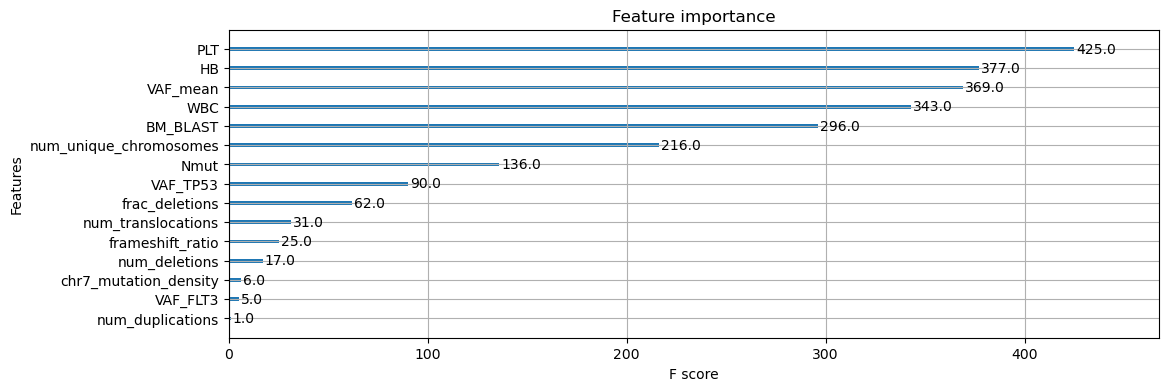

In [188]:
# It's marginally better
classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
classifier.fit(X3, y3)
fig, ax = plt.subplots(figsize=(12,4))
plot_importance(classifier, ax=ax)
plt.show();

In [90]:
df_eval['risk_score'] = weighted_preds  # Invert OS_YEARS to compute risk scores

# Create the final submission DataFrame
submission = df_eval[['ID', 'risk_score']].copy()

# Save to CSV
filename = 'EST_20'
submission.to_csv(f'./{filename}.csv', index=False)

print("Submission file has been created.")

Submission file has been created.


In [91]:
submission

,ID,risk_score
0,KYW1,432.656620
1,KYW2,468.427959
2,KYW3,256.532066
3,KYW4,399.243811
4,KYW5,435.042406
...,...,...
1188,KYW1189,185.735577
1189,KYW1190,195.932878
1190,KYW1191,196.970752
1191,KYW1192,182.184375


In [92]:
extra_trees.get_params(), features

({'bootstrap': True,
  'low_memory': False,
  'max_depth': 15,
  'max_features': 'sqrt',
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_samples_leaf': 3,
  'min_samples_split': 6,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 600,
  'n_jobs': 4,
  'oob_score': False,
  'random_state': 42,
  'verbose': 0,
  'warm_start': False},
 ['BM_BLAST',
  'HB',
  'WBC',
  'PLT',
  'Nmut',
  'num_unique_chromosomes',
  'frac_deletions',
  'num_deletions',
  'num_duplications',
  'VAF_mean',
  'frameshift_ratio',
  'num_translocations',
  'chr7_mutation_density',
  'VAF_TP53',
  'VAF_FLT3'])

In [93]:
model_params = dict(extra_trees.get_params())
model_params
with open(f'./{filename}.txt', 'w') as file:
    for item in features:
        file.write(item + '\n')
    for item, value in model_params.items():
        file.write(f'{item}={value}\n')
